## Training a sentiment analysis classifier based on supervised machine learning algorithms

In [87]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [88]:
pd.set_option('display.max_colwidth', None)

In [89]:
stop_words = set(stopwords.words('spanish'))

In [90]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [91]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_labeled.csv', sep = ',')

In [92]:
tweets_df.shape

(296, 2)

In [93]:
tweets_df.head()

,full_text,sentiment
0,@Nata_Salud @Sandrag69 @AndresMejiaV ¡Hola Natalia! Te invitamos a descubrir tu #MatchPresidencial aquí: https://t.co/0E1tZKypTK,neutral
1,@supershadai @Registraduria Quien o que institución en Colombia atiende los reclamos al fraude electoral?\r\nPorque no suspender a al registrador que ya la defeco en las elecciones de senado y camara.\r\nHay una desconfianza general en cuanto a las presidenciales.\r\nEstán provocando una respuesta violenta.,negative
2,@BOLIBAR2 @AndresPastrana_ @santiagoangelp Un poco tarde con las elecciones encima… mal para Colombia,negative
3,"No encontraron otra alternativa que llenar de miedo a Colombia, utilizan sus paramilitares para ganar elecciones. Es ahora o nunca @petrogustavo",positive
4,"@BOLIBAR2 @CNE_COLOMBIA @AndresPastrana_ Aquí no va a pasar nada, y petro de va a robar las elecciones presidenciales y el país",negative


In [94]:
#Manually change the tweets that were false positive and false negative
tweets_df = pd.read_csv('./data/tweets - Modificados según resultados.csv', sep = ',')

In [95]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.702703
neutral     0.233108
positive    0.064189
Name: sentiment, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [96]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [97]:
tweets_labeled_df.shape

(296, 2)

In [98]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [99]:
tweets_unlabeled_df.shape

(0, 2)

In [100]:
# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral':'positive'})

### Splitting train and test datasets

In [101]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [102]:
X_train.shape

(236,)

In [103]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.70339
positive    0.29661
Name: sentiment, dtype: float64

In [104]:
X_test.shape

(60,)

In [105]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.7
positive    0.3
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [106]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [107]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [108]:
X_bow = bow.fit_transform(X_train)

In [109]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [110]:
model = RandomForestClassifier()

In [111]:
model.fit(X_bow, y_train)

RandomForestClassifier()

In [112]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

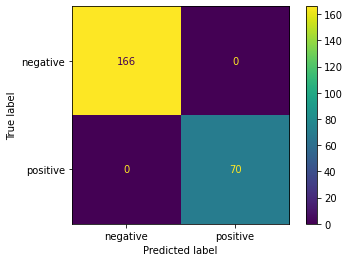

In [113]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

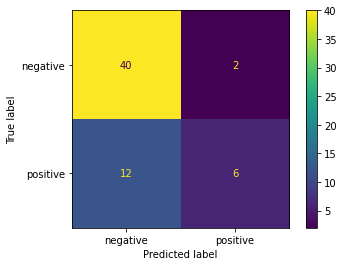

In [114]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [115]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.76923077 0.75      ]
Recall: [0.95238095 0.33333333]
F1: [0.85106383 0.46153846]


### Training and evaluating a model using TF-IDF

In [116]:
model = RandomForestClassifier()

In [117]:
model.fit(X_tfidf, y_train)

RandomForestClassifier()

In [118]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

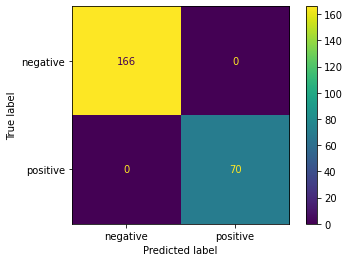

In [119]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

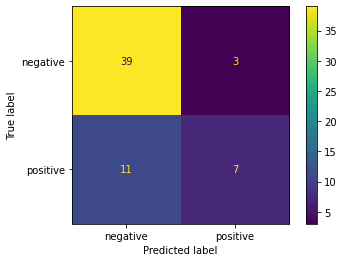

In [120]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [121]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.78 0.7 ]
Recall: [0.92857143 0.38888889]
F1: [0.84782609 0.5       ]


### How interpret the results?

### Analyzing errors Bag of Words

In [122]:
error_df1 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df1.drop('index', inplace = True, axis = 1)

In [123]:
error_df1.shape

(60, 3)

In [124]:
error_df1.loc[error_df1['actual'] != error_df1['predicted']].head(20)

,full_text,actual,predicted
3,#ElRiesgoEs 🇨🇴\r\n➖➖➖\r\n1.- permitir que llegue al poder el comunismo y el socialismo del siglo XXI.\r\n2.- no votar en conciencia.\r\n3.- la compra de conciencias débiles… muy débiles.❌\r\n\r\n#Colombia #Medellín #Elecciones #Política @LaFM @darcyquinnr @lcvelez @FicoGutierrez @ifmnoticias,negative,positive
8,"@tinagus2000 Evidentemente la persecución judicial, la aceleración de cosas, las trabas del @cnegobec para la inscripción , el viaje de la fiscal a Colombia y el papel de otras instituciones influyeron en la victoria de Lasso. Al otro candidato lo desgastaron, mucha antes de las elecciones.",positive,negative
16,"@correawilly @CNE_COLOMBIA Leído los documentos provenientes de cada circunscripción territorial y de la internacional, se declaró el resultado de la Cámara por circunscripción internacional y se recibieron más de 1000 solicitudes y reclamaciones respecto de elecciones de Senado y Cámaras étnicas, …",positive,negative
17,¡Viva Petro!\r\nColombia | Petro anuncia que si gana restablecerá las relaciones diplomáticas y consulares con Venezuela @InfoNodal https://t.co/VjYoQsWoY1,negative,positive
20,"2.925 jurados de votación estarían inhabilitados para estar en las elecciones presidenciales, ¿por qué? ⬇ https://t.co/QvDgqo11wV",positive,negative
23,Me salió esto 😅\r\n\r\nhttps://t.co/TJokUajStC,positive,negative
24,"@condeza6 @Gonzalo00333993 @Pura_Miel @Registraduria @CNE_COLOMBIA @moecolombia @PGN_COL Coño que porquería de país , acaso la procuradora se revolcó con el registrador y le tomo fotos y videos que la tiene chantajeada o que , que carajos es lo que esa vieja está esperando que se forme un mierdero el día de las elecciones?",positive,negative
31,Estos son los tarjetones con los que Colombia ha votado a la presidencia en 28 años:\r\n\r\nhttps://t.co/7jcyCwQuni,positive,negative
32,Elecciones en Colombia: el silencio que decidirá al ganador https://t.co/lHH5JFvDd9,positive,negative
41,Comenzaron los simulacros de las elecciones de Presidente y Vicepresidente de 2022 en Colombia https://t.co/DVamXNXiGC,positive,negative


### Analyzing errors TF-IDF

In [125]:
error_df2 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df2.drop('index', inplace = True, axis = 1)

In [126]:
error_df2.shape

(60, 3)

In [127]:
error_df2.loc[error_df2['actual'] != error_df2['predicted']].head(20)

,full_text,actual,predicted
3,#ElRiesgoEs 🇨🇴\r\n➖➖➖\r\n1.- permitir que llegue al poder el comunismo y el socialismo del siglo XXI.\r\n2.- no votar en conciencia.\r\n3.- la compra de conciencias débiles… muy débiles.❌\r\n\r\n#Colombia #Medellín #Elecciones #Política @LaFM @darcyquinnr @lcvelez @FicoGutierrez @ifmnoticias,negative,positive
8,"@tinagus2000 Evidentemente la persecución judicial, la aceleración de cosas, las trabas del @cnegobec para la inscripción , el viaje de la fiscal a Colombia y el papel de otras instituciones influyeron en la victoria de Lasso. Al otro candidato lo desgastaron, mucha antes de las elecciones.",positive,negative
16,"@correawilly @CNE_COLOMBIA Leído los documentos provenientes de cada circunscripción territorial y de la internacional, se declaró el resultado de la Cámara por circunscripción internacional y se recibieron más de 1000 solicitudes y reclamaciones respecto de elecciones de Senado y Cámaras étnicas, …",positive,negative
17,¡Viva Petro!\r\nColombia | Petro anuncia que si gana restablecerá las relaciones diplomáticas y consulares con Venezuela @InfoNodal https://t.co/VjYoQsWoY1,negative,positive
18,Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia\r\n#TalCual #ClaroyRaspao #AmigosDeNuevo \r\nhttps://t.co/Kpm7VZydwZ https://t.co/xyy0uPwwzZ,negative,positive
20,"2.925 jurados de votación estarían inhabilitados para estar en las elecciones presidenciales, ¿por qué? ⬇ https://t.co/QvDgqo11wV",positive,negative
23,Me salió esto 😅\r\n\r\nhttps://t.co/TJokUajStC,positive,negative
24,"@condeza6 @Gonzalo00333993 @Pura_Miel @Registraduria @CNE_COLOMBIA @moecolombia @PGN_COL Coño que porquería de país , acaso la procuradora se revolcó con el registrador y le tomo fotos y videos que la tiene chantajeada o que , que carajos es lo que esa vieja está esperando que se forme un mierdero el día de las elecciones?",positive,negative
31,Estos son los tarjetones con los que Colombia ha votado a la presidencia en 28 años:\r\n\r\nhttps://t.co/7jcyCwQuni,positive,negative
32,Elecciones en Colombia: el silencio que decidirá al ganador https://t.co/lHH5JFvDd9,positive,negative
